In [ ]:
# Install pylibCZIrw and dependencies
#! pip install --upgrade pip
#! pip install "pylibCZIrw~=4.0" "cztile>=0.0,<1.0" matplotlib tqdm scikit-image pooch requests

# pylibCZIrw - Tutorial

In this notebook one can see how to read and write CZI (Carl Zeiss Image) files using from Python using **[pylibCZIrw](https://pypi.org/project/pylibczirw/)**. This package is wrapper for the **libCZIrw** (C++) library and can be used both in Windows and Linux.

## Remarks

* At the moment, **[pylibCZIrw](https://pypi.org/project/pylibczirw/)** completely abstracts away the subblock concept, both in the reading and in the writing APIs.
* If [pylibCZIrw](https://pypi.org/project/pylibczirw/) is extended in the future to support subblock-based access (e.g. accessing acquisition tiles), this API must not be altered.

## Disclaimer

This notebook is free to use for everybody. Carl Zeiss Microscopy GmbH's ZEN software undertakes no warranty concerning the use of those scripts, image analysis settings and ZEN experiments. Use them on your own risk.

Additionally Carl Zeiss Microscopy GmbH's ZEN software allows connection and usage to the third party software packages.
Therefore Carl Zeiss Microscopy GmbH undertakes no warranty concerning those software packages, makes no representation that they will work on your system and/or hardware and will not be liable for any damages caused by the use of this extension. **By using any of those examples you agree to this disclaimer.**

Version: 2022.02.09

Copyright (c) 2022 Carl Zeiss AG, Germany. All Rights Reserved.

## Required Module Imports

Both reading and writing APIs are contained within the **czi** object in pylibCZIrw, so let's start by importing it.

Additional modules are imported alongside the **pylibCZIrw** package.

In [1]:
from pylibCZIrw import czi as pyczi
import json
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os, sys
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from cellpose import utils
import cv2
from scipy import ndimage
from pathlib import Path
import pandas as pd


# show the used python env
print("Using:", sys.executable)

Using: C:\Users\chrism\miniconda3\envs\cellpose\python.exe


## Opening a CZI (read-only)

A CZI file can be opened in a context manager using a [path-like-object](https://docs.python.org/3/library/os.html#os.PathLike) (in this case, file_path).

`with czi.open_czi(file_path) as czi:`

**This will open the CZI in read-only mode.**

The **`total_bounding_rectangle`** gives us the X and Y dimensions of the CZI, i.e. the (X, Y) of the **`total_bounding_box`**.

Text(0.5, 1.0, 'F4/80')

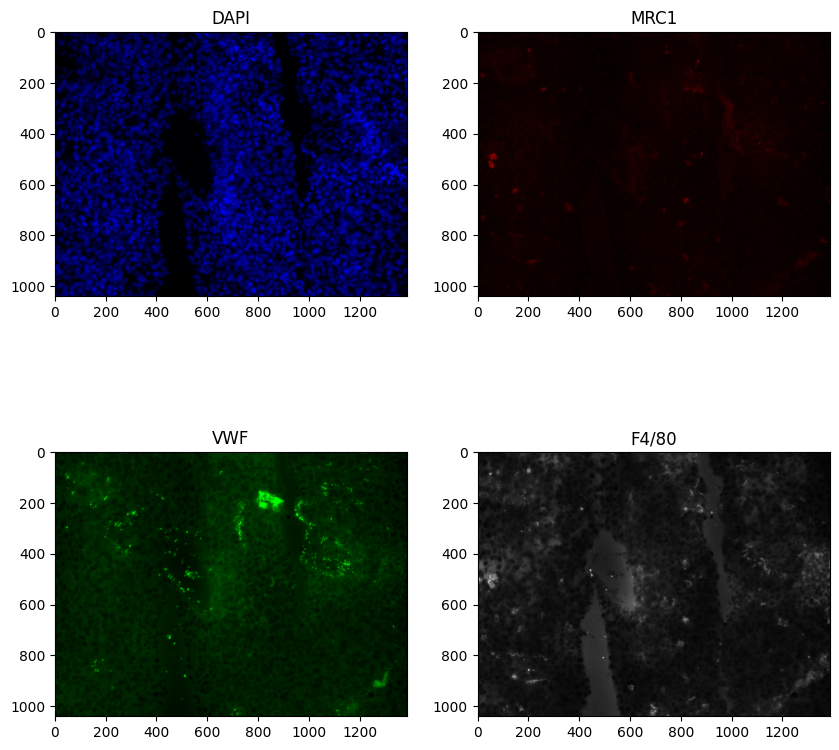

In [2]:
czifile = "Snap-155460.czi"

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

with pyczi.open_czi(czifile) as czidoc:
    ch0 = czidoc.read(plane={'C': 0})
    dapi = ch0[..., 0]
    ch1 = czidoc.read(plane={'C': 1})
    mrc1 = ch1[..., 0]
    ch2 = czidoc.read(plane={'C': 2})
    vwf = ch2[..., 0]
    ch3 = czidoc.read(plane={'C': 3})
    f480 = ch3[..., 0]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dapi, cmap=cm_blue)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf, cmap=cm_green)
ax[1,0].set_title("VWF")

# F4/80
ax[1,1].imshow(f480, cmap=cm_white)
ax[1,1].set_title("F4/80")

In [ ]:
npyfile = "Snap-155522_c1+2+3+4_seg.npy"
dat = np.load(npyfile, allow_pickle=True).item()
num_cells = dat["masks"].max()
masks = dat["masks"]
slices = utils.find_objects(masks)
num_cells = len(slices)
for i,si in enumerate(slices):
    if si is not None:
        sr,sc = si
        mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        pvc, pvr = np.concatenate(contours[-2], axis=0).squeeze().T  
        ypix, xpix = np.nonzero(mask)
        min_dist = ((ypix[:,np.newaxis] - pvr)**2 + 
                    (xpix[:,np.newaxis] - pvc)**2).min(axis=1)
        # dist_to_bound[ypix + sr.start, xpix + sc.start] = min_distfig, ax = plt.subplots()


In [ ]:
fig, ax = plt.subplots()
ax.imshow(mrc1)
ax.imshow(masks)
cs = ndimage.center_of_mass(mrc1, masks, index=np.arange(0,num_cells))
xs, ys = zip(*cs)
ax.scatter(ys, xs, c="yellow", marker=".")

for y,x in cs:
    print(x,y)


In [ ]:
masks

In [ ]:
npyfile = "Snap-155522_c1+2+3+4_exclude.npy"
dat = np.load(npyfile, allow_pickle=True).item()
exclude = dat["masks"]>0
plt.imshow(exclude)

In [ ]:
dapi[exclude > 0] = 0
mrc1[exclude > 0] = 0
vwf[exclude > 0] = 0
f480[exclude > 0] = 0

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dapi, cmap=cm_blue)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf, cmap=cm_green)
ax[1,0].set_title("VWF")

# F4/80
ax[1,1].imshow(f480, cmap=cm_white)
ax[1,1].set_title("F4/80")

In [ ]:
slices = utils.find_objects(masks)

for i,si in enumerate(slices):
    if np.any((masks == i+1) & exclude):
        print(f"Cell {i+1} intersecting exclude region. Skipping ...")
        continue
    if si is not None:
        sr,sc = si
        mask = masks[sr, sc] != (i+1)
        dapi_ma = ma.masked_array(dapi[sr, sc], mask)
        mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
        vwf_ma = ma.masked_array(vwf[sr, sc], mask)
        f480_ma = ma.masked_array(f480[sr, sc], mask)
        mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
        print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dapi_ma, cmap=cm_blue)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1_ma, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf_ma, cmap=cm_green)
ax[1,0].set_title("VWF")

# F4/80
ax[1,1].imshow(f480_ma, cmap=cm_white)
ax[1,1].set_title("F4/80")

In [ ]:
radius = 35
x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
weights = (arr - arr.max()) * -1

cs = ndimage.center_of_mass(mrc1, masks, index=np.arange(0,num_cells))
# xs, ys = zip(*cs)
for y,x in cs:
    print(x,y)
    x = round(x)
    y = round(y)
    sr = slice(y-radius, y+radius+1)
    sc = slice(x-radius, x+radius+1)
    region = vwf[sr, sc]
    vwf_mean = np.average(region, weights=weights)
    print(vwf_mean)
    


In [ ]:
# load czi
# load cell masks
# load exclude masks
# mask czi channels with exclude masks (set 0)
# discard cells intersecting exclude masks

In [ ]:
vwf_ma.sum()

In [ ]:
data_path = Path('C:\\Users\\chrism\\tmp\\Makrophagen Zeiss')
area_pixel = 0.512 * 0.512
cells_path = data_path / "Cells"
czi_path = data_path / "CZI"
exclude_path = data_path / "Exclude"
debug_path = data_path / "debug"
radius = 35
debug = True
results = []

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
weights = (arr - arr.max()) * -1

for cell_masks_file in cells.glob("**/*.npy"):
    print(cell_masks_file)
    slide = cell_masks_file.parent.parts[-1]
    group = cell_masks_file.parent.parts[-2]
    
    exclude_masks = exclude_path / group / slide / cell_masks_file.name
    if not exclude_masks.exists():
        print(f"{exclude_masks} does not exist. Skipping ...")
        continue
        
    czi_file_name = cell_masks_file.name[0:-17] + '.czi'
    czi_file = czi_path / group / slide / czi_file_name
    if not czi_file.exists():
        print(f"{czi_file} does not exist. Skipping ...")
        continue

    cell_seg = np.load(cell_masks_file, allow_pickle=True).item()
    cell_masks = cell_seg["masks"]
    num_cells = cell_masks.max()
    
    exclude_seg = np.load(exclude_masks, allow_pickle=True).item()
    exclude_masks = exclude_seg["masks"] > 0
    
    num_pixels = exclude_masks.shape[0] * exclude_masks.shape[1] - np.count_nonzero(exclude_masks)
    area = num_pixels * area_pixel
    # print(area)
    cells_per_um2 = num_cells / area
    # print(cells_per_um2)

    with pyczi.open_czi(str(czi_file)) as czidoc:
        ch0 = czidoc.read(plane={'C': 0})
        dapi = ch0[..., 0]
        ch1 = czidoc.read(plane={'C': 1})
        mrc1 = ch1[..., 0]
        ch2 = czidoc.read(plane={'C': 2})
        vwf = ch2[..., 0]
        ch3 = czidoc.read(plane={'C': 3})
        f480 = ch3[..., 0]

    if debug:
        plt.ioff()
        fig, ax = plt.subplots(figsize=(13, 10))
        ax.imshow(mrc1, cmap=cm_red)
   
    slices = utils.find_objects(cell_masks)
    cell_centers = ndimage.center_of_mass(mrc1, cell_masks, index=np.arange(0, num_cells))

    for i, (si, (row, col)) in enumerate(zip(slices, cell_centers)): 
        if np.any((cell_masks == i+1) & exclude_masks):
            print(f"Cell {i+1} intersecting exclude region. Skipping ...")
            continue
        if si is not None:
            sr, sc = si
            mask = cell_masks[sr, sc] != (i+1)
            dapi_ma = ma.masked_array(dapi[sr, sc], mask)
            mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
            vwf_ma = ma.masked_array(vwf[sr, sc], mask)
            f480_ma = ma.masked_array(f480[sr, sc], mask)
            mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
            f480_mrc1_ratio = f480_ma.sum() / mrc1_ma.sum()
            # print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")
        
        corrected_weights = weights
        # print(row, col)
        row = round(row)
        col = round(col)
        
        if row - radius < 0:
            row_start = 0
            corrected_weights = corrected_weights[radius - row:, :]
        else:
            row_start = row - radius

        if row + radius > 1039:
            row_end = 1039
            corrected_weights = corrected_weights[:-1 * ((row + radius + 1) - 1039), :]
        else:
            row_end = row + radius + 1

        if col - radius < 0:
            col_start = 0
            corrected_weights = corrected_weights[:, radius - col:]
        else:
            col_start = col - radius

        if col + radius > 1387:
            col_end = 1387
            corrected_weights = corrected_weights[:, :-1 * ((col + radius + 1) - 1387)]
        else:
            col_end = col + radius + 1
        
        region = vwf[row_start:row_end, col_start:col_end]
        vwf_mean = np.average(region, weights=corrected_weights)
        # print(vwf_mean)

        results_row = {'group': group, 'slide': slide, 'czi': czi_file_name, 'cell_no': i, 'mrc1/f480': mrc1_f480_ratio, 'f480/mrc1': f480_mrc1_ratio, 'mean(vwf)': vwf_mean}
        results.append(results_row)

        if debug:
            ax.text(col, row, str(i), color="white")

    if debug:
        debug_file_name = cell_masks_file.name + ".png"
        debug_file = debug_path / group / slide / debug_file_name
        debug_file.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(debug_file))
        plt.close(fig)
        plt.ion()
        
df = pd.DataFrame(results)
out_fn = f"results_radius={radius}.xlsx"
df.to_excel(data_path / out_fn)

In [ ]:
region.shape

In [ ]:
corrected_weights.shape

In [ ]:
weights.shape